In [58]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Velocidades circulares - GADGET

In [59]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

# path = '/home/ornela/SimCLUES/'
path = '/home/omarioni/'
atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

path = '/mnt/is2/alejandro/ornella/'

snapshot=range(496,495,-1)

for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp[0] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[0]/h
        ystr = (pstr[:,1]-cm[1])*aexp[0]/h
        zstr = (pstr[:,2]-cm[2])*aexp[0]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[0]/h
        ygas = (pgas[:,1]-cm[1])*aexp[0]/h
        zgas = (pgas[:,2]-cm[2])*aexp[0]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[0]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[0]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[0]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[0]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[0]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[0]) + Ht *zstr/1000.
#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h
        
        r200 = r200*aexp[0]/h
        
        print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        limit_str   = np.where(rstr<r200)
        rstr_sort   = np.sort(rstr[limit_str])
        rstr_indice = np.argsort(rstr[limit_str])
        
        limit_gas   = np.where(rgas<r200)
        rgas_sort   = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((mstr[limit])[r_indice])
        
        Mc_str = cumsum((mstr[limit_str])[rstr_indice])
        
        Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mgal_str[-1]
    
        razon       = Mgal_str/M_gal
        setentaycinco,= np.where(razon < 0.75)
        cincuenta,    = np.where(razon < 0.50)
        veinticinco,  = np.where(razon < 0.25)
        
        r75 = r_sort[setentaycinco][-1]
        r50 = r_sort[cincuenta][-1]
        r25 = r_sort[veinticinco][-1]
#--------------------------------------------------------------       
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/rstr_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
#----------------------------------------------------------------------------------

        data_tot = np.zeros([np.size(rtot_sort),3])
        data_tot[:,0]= rtot_sort
        data_tot[:,1]= Vtot
        data_tot[:,2]= Mc_tot*1e10
        
        data_str = np.zeros([np.size(rstr_sort),3])
        data_str[:,0]= rstr_sort
        data_str[:,1]= Vstr
        data_str[:,2]= Mc_str*1e10
        
        data_gas = np.zeros([np.size(rgas_sort),3])
        data_gas[:,0]= rgas_sort
        data_gas[:,1]= Vgas
        data_gas[:,2]= Mc_gas*1e10
        
        data_drk = np.zeros([np.size(rdrk_sort),3])
        data_drk[:,0]= rdrk_sort
        data_drk[:,1]= Vdrk
        data_drk[:,2]= Mc_drk*1e10
        
        data = np.ndarray([5,1])
        data[0] = r200
        data[1] = r50
        data[2] = r25
        data[3] = r75
        data[4] = M_gal*1e10

        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vtot.dat', data_tot)
        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vstr.dat', data_str)
        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vgas.dat', data_gas)
        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vdrk.dat', data_drk)
        np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_radios.dat', data)

r200 = 167.210382514
r200 = 153.542349727
r200 = 123.112021858


### Velocidades circulares - GASOLINE

In [61]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
G = 4.299e-6
a0 =1.

path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path+'Gasoline/snapshots.txt', dtype='string')


snap = h5py.File(path+'Gasoline/outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    
    omega_lambda = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaL0'].value
    omega_matter = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaM0'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
    mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

    H0 = h*100
    z = a0/aexp - 1.
    omega0 = omega_lambda + omega_matter
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0]) #*aexp
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    #v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    #v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
    
    v_x = vel[:,0] 
    v_y = vel[:,1] 
    v_z = vel[:,2]

#------------------------------------------------
    r200 = r200*aexp
    
    print 'r200=', r200
    rgal=0.15*r200

    limit    = np.where(rstr<rgal)
    r_sort   = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    limit_str   = np.where(rstr<r200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<r200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<r200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = cumsum((mstr[limit])[r_indice])

    Mc_str = cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])

#------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon       = Mgal_str/M_gal
    setentaycinco,= np.where(razon < 0.75)
    cincuenta,    = np.where(razon < 0.50)
    veinticinco,  = np.where(razon < 0.25)

    r75 = r_sort[setentaycinco][-1]
    r50 = r_sort[cincuenta][-1]
    r25 = r_sort[veinticinco][-1]
#--------------------------------------------------------------       
    rtot= concatenate([rstr, rgas, rdrk])
    mtot= concatenate([mstr, mgas, mdrk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])
    
    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])


#calculo rvir------------------------------------------
    '''rho_crit=3*(H0/1000)**2/(8*pi*G)
    rho=Mc_tot1*3/(4*pi*rtot_sort1**3)
    delta=rho/rho_crit
    kk=np.where(delta<200)
    rvir=rtot_sort1[kk]
    print rvir[0],(delta[kk])[0]'''
#--------------------------------------------------------------
    Mc_tot = Mc_tot[1:]
    Mc_str = Mc_str[1:]
    Mc_gas = Mc_gas[1:]
    Mc_drk = Mc_drk[1:]

    rtot_sort = rtot_sort[1:]
    rstr_sort = rstr_sort[1:]
    rgas_sort = rgas_sort[1:]
    rdrk_sort = rdrk_sort[1:]

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)

#----------------------------------------------------------------------------------

    data_tot = np.zeros([np.size(rtot_sort),3])
    data_tot[:,0]= rtot_sort
    data_tot[:,1]= Vtot
    data_tot[:,2]= Mc_tot

    data_str = np.zeros([np.size(rstr_sort),3])
    data_str[:,0]= rstr_sort
    data_str[:,1]= Vstr
    data_str[:,2]= Mc_str

    data_gas = np.zeros([np.size(rgas_sort),3])
    data_gas[:,0]= rgas_sort
    data_gas[:,1]= Vgas
    data_gas[:,2]= Mc_gas

    data_drk = np.zeros([np.size(rdrk_sort),3])
    data_drk[:,0]= rdrk_sort
    data_drk[:,1]= Vdrk
    data_drk[:,2]= Mc_drk

    data = np.ndarray([5,1])
    data[0] = r200
    data[1] = r50
    data[2] = r25
    data[3] = r75
    data[4] = M_gal

    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vtot.dat', data_tot)
    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vstr.dat', data_str)
    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vgas.dat', data_gas)
    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vdrk.dat', data_drk)
    np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_radios.dat', data)

r200= 166.840000002
r200= 150.460000002
r200= 119.620000002


## Leemos datos galaxias GADGET

In [62]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vtot.dat')
rtot_M31gd = M31_gd[:,0]
Vtot_M31gd = M31_gd[:,1]
Mtot_M31gd = M31_gd[:,2]

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vstr.dat')
rstr_M31gd = M31_gd[:,0]
Vstr_M31gd = M31_gd[:,1]
Mstr_M31gd = M31_gd[:,2]

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vgas.dat')
rgas_M31gd = M31_gd[:,0]
Vgas_M31gd = M31_gd[:,1]
Mgas_M31gd = M31_gd[:,2]

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vdrk.dat')
rdrk_M31gd = M31_gd[:,0]
Vdrk_M31gd = M31_gd[:,1]
Mdrk_M31gd = M31_gd[:,2]

#---------------------------------------------------------------------------------------------

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vtot.dat')
rtot_MWgd = MW_gd[:,0]
Vtot_MWgd = MW_gd[:,1]
Mtot_MWgd = MW_gd[:,2]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vstr.dat')
rstr_MWgd = MW_gd[:,0]
Vstr_MWgd = MW_gd[:,1]
Mstr_MWgd = MW_gd[:,2]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vgas.dat')
rgas_MWgd = MW_gd[:,0]
Vgas_MWgd = MW_gd[:,1]
Mgas_MWgd = MW_gd[:,2]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vdrk.dat')
rdrk_MWgd = MW_gd[:,0]
Vdrk_MWgd = MW_gd[:,1]
Mdrk_MWgd = MW_gd[:,2]

#-------------------------------------------------------------------------------------------

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Vtot.dat')
rtot_M33gd = M33_gd[:,0]
Vtot_M33gd = M33_gd[:,1]
Mtot_M33gd = M33_gd[:,2]

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Vstr.dat')
rstr_M33gd = M33_gd[:,0]
Vstr_M33gd = M33_gd[:,1]
Mstr_M33gd = M33_gd[:,2]

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Vgas.dat')
rgas_M33gd = M33_gd[:,0]
Vgas_M33gd = M33_gd[:,1]
Mgas_M33gd = M33_gd[:,2]

M33_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_Vdrk.dat')
rdrk_M33gd = M33_gd[:,0]
Vdrk_M33gd = M33_gd[:,1]
Mdrk_M33gd = M33_gd[:,2]

## Leemos datos galaxias GASOLINE

In [63]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vtot.dat')
rtot_M31gs = M31_gs[:,0]
Vtot_M31gs = M31_gs[:,1]
Mtot_M31gs = M31_gs[:,2]

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vstr.dat')
rstr_M31gs = M31_gs[:,0]
Vstr_M31gs = M31_gs[:,1]
Mstr_M31gs = M31_gs[:,2]

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vgas.dat')
rgas_M31gs = M31_gs[:,0]
Vgas_M31gs = M31_gs[:,1]
Mgas_M31gs = M31_gs[:,2]

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vdrk.dat')
rdrk_M31gs = M31_gs[:,0]
Vdrk_M31gs = M31_gs[:,1]
Mdrk_M31gs = M31_gs[:,2]

#---------------------------------------------------------------------------------------------

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vtot.dat')
rtot_MWgs = MW_gs[:,0]
Vtot_MWgs = MW_gs[:,1]
Mtot_MWgs = MW_gs[:,2]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vstr.dat')
rstr_MWgs = MW_gs[:,0]
Vstr_MWgs = MW_gs[:,1]
Mstr_MWgs = MW_gs[:,2]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vgas.dat')
rgas_MWgs = MW_gs[:,0]
Vgas_MWgs = MW_gs[:,1]
Mgas_MWgs = MW_gs[:,2]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vdrk.dat')
rdrk_MWgs = MW_gs[:,0]
Vdrk_MWgs = MW_gs[:,1]
Mdrk_MWgs = MW_gs[:,2]

#-------------------------------------------------------------------------------------------

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Vtot.dat')
rtot_M33gs = M33_gs[:,0]
Vtot_M33gs = M33_gs[:,1]
Mtot_M33gs = M33_gs[:,2]

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Vstr.dat')
rstr_M33gs = M33_gs[:,0]
Vstr_M33gs = M33_gs[:,1]
Mstr_M33gs = M33_gs[:,2]

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Vgas.dat')
rgas_M33gs = M33_gs[:,0]
Vgas_M33gs = M33_gs[:,1]
Mgas_M33gs = M33_gs[:,2]

M33_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_Vdrk.dat')
rdrk_M33gs = M33_gs[:,0]
Vdrk_M33gs = M33_gs[:,1]
Mdrk_M33gs = M33_gs[:,2]

In [64]:
path = '/home/omarioni/'

radios_M31gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_radios.dat')
r200_M31gd = radios_M31gd[0]
r50_M31gd  = radios_M31gd[1]
r25_M31gd  = radios_M31gd[2]
r75_M31gd  = radios_M31gd[3]
Mgal_M31gd = radios_M31gd[4]

radios_MWgd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_radios.dat')
r200_MWgd = radios_MWgd[0]
r50_MWgd  = radios_MWgd[1]
r25_MWgd  = radios_MWgd[2]
r75_MWgd  = radios_MWgd[3]
Mgal_MWgd = radios_MWgd[4]

radios_M33gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_radios.dat')
r200_M33gd = radios_M33gd[0]
r50_M33gd  = radios_M33gd[1]
r25_M33gd  = radios_M33gd[2]
r75_M33gd  = radios_M33gd[3]
Mgal_M33gd = radios_M33gd[4]

radios_M31gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_radios.dat')
r200_M31gs = radios_M31gs[0]
r50_M31gs  = radios_M31gs[1]
r25_M31gs  = radios_M31gs[2]
r75_M31gs  = radios_M31gs[3]
Mgal_M31gs = radios_M31gs[4]

radios_MWgs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_radios.dat')
r200_MWgs = radios_MWgs[0]
r50_MWgs  = radios_MWgs[1]
r25_MWgs  = radios_MWgs[2]
r75_MWgs  = radios_MWgs[3]
Mgal_MWgs = radios_MWgs[4]

radios_M33gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_radios.dat')
r200_M33gs = radios_M33gs[0]
r50_M33gs  = radios_M33gs[1]
r25_M33gs  = radios_M33gs[2]
r75_M33gs  = radios_M33gs[3]
Mgal_M33gs = radios_M33gs[4]

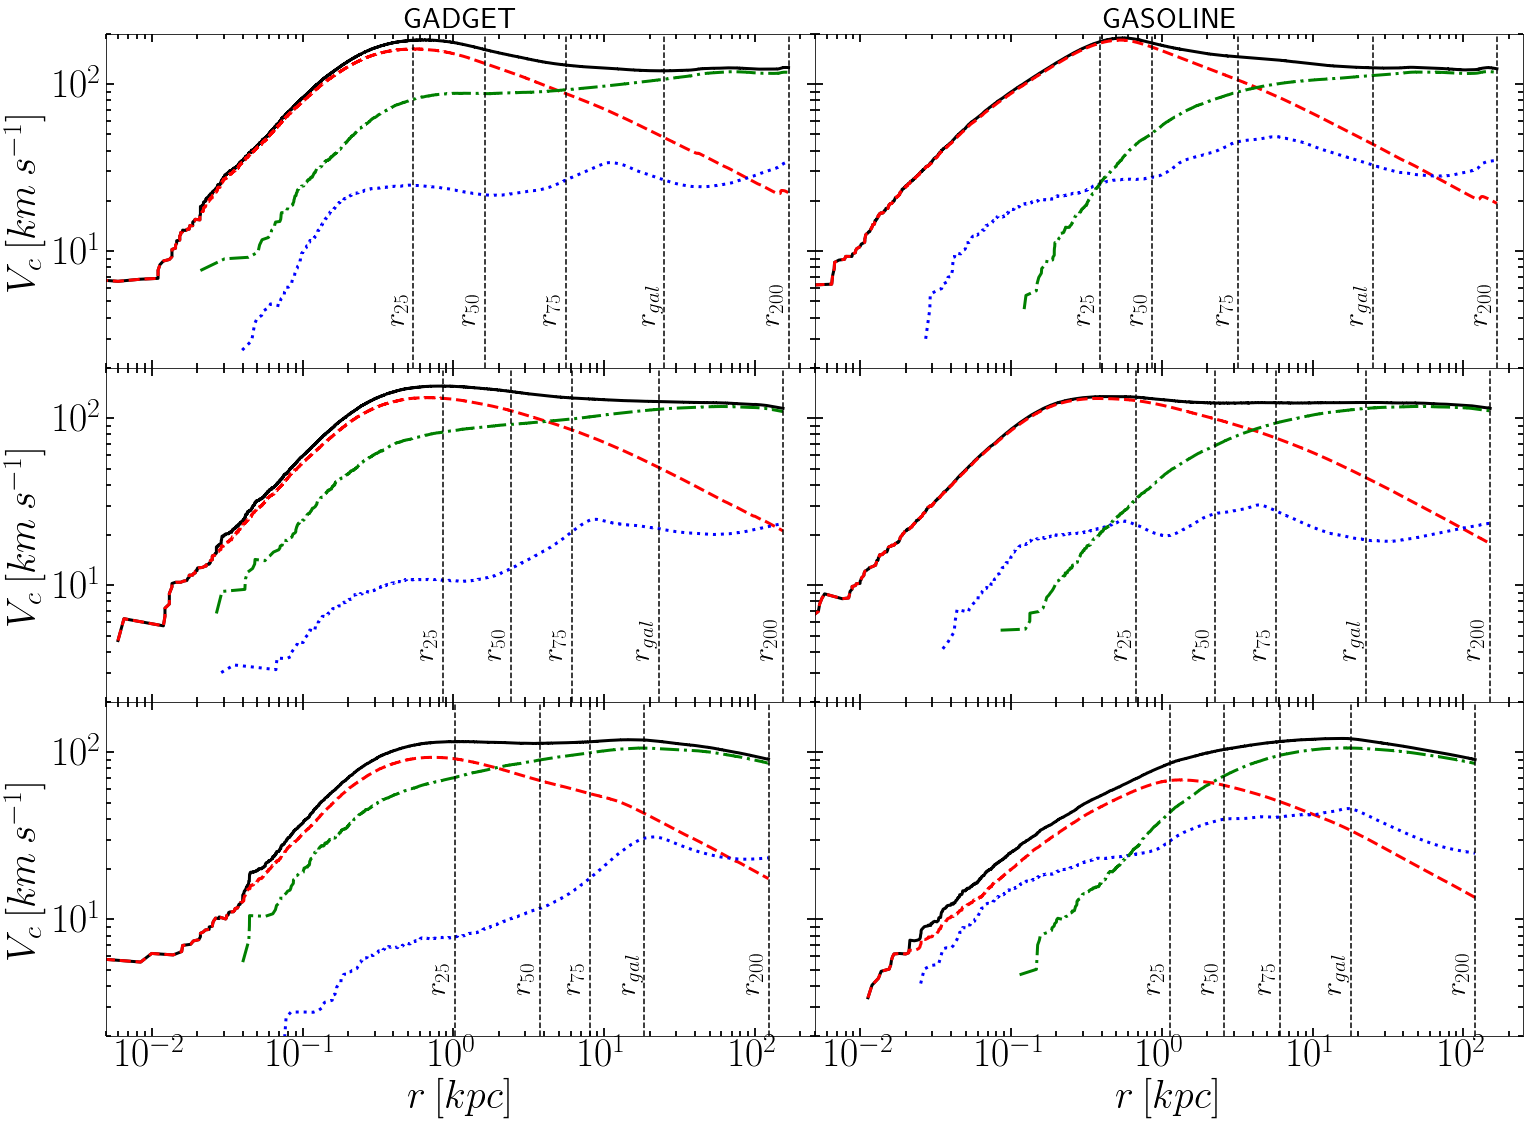

In [104]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))# sharey=True, sharex=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
ax[0,0].plot(rtot_M31gd, Vtot_M31gd, '-', lw=3, color='k', label= 'Total')
ax[0,0].plot(rstr_M31gd, Vstr_M31gd, '--',lw=3, color='r', label ='Stars')
ax[0,0].plot(rgas_M31gd, Vgas_M31gd, ':', color ='b',lw=3, label='Gas')
ax[0,0].plot(rdrk_M31gd, Vdrk_M31gd, '-.',color='g', lw=3, label='Dark Matter')

# ax[0,0].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)

ax[0,0].set_ylim(2,200)
ax[0,0].set_xlim(0.005,250)
ax[0,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')

ax[0,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[0,0].set_xticklabels([])
ax[0,0].set_yticks([1e1,1e2], minor=True)

ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[0,0].axvline(r200_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r200_M31gd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r200_M31gd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r200_M31gd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r50_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r50_M31gd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[0,0].axvline(r25_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r25_M31gd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,0].axvline(r75_M31gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,0].text(r75_M31gd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


# ax[0,0].annotate('', xy=(20,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), 
#                  textcoords='data' ,ha="right", va='center', arrowprops=dict(facecolor='k',ec="none"))

# ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')

ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#------------------------------------------------------

# # ax2=fig.add_subplot(222)
ax[0,1].plot(rtot_M31gs, Vtot_M31gs, '-', lw=3, color='k', label= 'Total')
ax[0,1].plot(rstr_M31gs, Vstr_M31gs, '--',lw=3, color='r', label ='Stars')
ax[0,1].plot(rgas_M31gs, Vgas_M31gs, ':', color ='b',lw=3, label='Gas')
ax[0,1].plot(rdrk_M31gs, Vdrk_M31gs, '-.',color='g', lw=3, label='Dark Matter')

# # ax[0,1].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
ax[0,1].set_ylim(2,200)
ax[0,1].set_xlim(0.005,250)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

ax[0,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticks([1e1,1e2], minor=True)
ax[0,1].set_yticklabels([])

ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[0,1].axvline(r200_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r200_M31gs, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r200_M31gs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r200_M31gs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r50_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r50_M31gs, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r25_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r25_M31gs, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].axvline(r75_M31gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[0,1].text(r75_M31gs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)


# #---------------------------------------------------------

# # ax3=fig.add_subplot(223)
ax[1,0].plot(rtot_MWgd,Vtot_MWgd,'-', lw=3, color='k', label= 'Total')
ax[1,0].plot(rstr_MWgd,Vstr_MWgd,'--',lw=3, color='r', label ='Stars')
ax[1,0].plot(rgas_MWgd,Vgas_MWgd,':', color ='b',lw=3, label='Gas')
ax[1,0].plot(rdrk_MWgd,Vdrk_MWgd,'-.',color='g', lw=3, label='Dark Matter')

ax[1,0].set_ylim(2,200)
ax[1,0].set_xlim(0.005,250)
# ax[1,0].set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax[1,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[1,0].set_xticklabels([])
ax[1,0].set_yticks([1e1,1e2], minor=True)

ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[1,0].axvline(r200_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r200_MWgd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r200_MWgd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r200_MWgd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r50_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r50_MWgd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r25_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r25_MWgd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[1,0].axvline(r75_MWgd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,0].text(r75_MWgd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

# #---------------------------------------------------------------------------------------
# # ax4=fig.add_subplot(224)
ax[1,1].plot(rtot_MWgs,Vtot_MWgs,'-', lw=3, color='k', label= 'Total')
ax[1,1].plot(rstr_MWgs,Vstr_MWgs,'--',lw=3, color='r', label ='Stars')
ax[1,1].plot(rgas_MWgs,Vgas_MWgs,':', color ='b',lw=3, label='Gas')
ax[1,1].plot(rdrk_MWgs,Vdrk_MWgs,'-.',color='g', lw=3, label='Dark Matter')

# # ax[1,1].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')

ax[1,1].set_ylim(2,200)
ax[1,1].set_xlim(0.005,250)
# ax[1,1].set_xlabel(r'$r\:[kpc]$',fontsize=40)
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[1,1].set_xticklabels([])
ax[1,1].set_yticks([1e1,1e2], minor=True)
ax[1,1].set_yticklabels([])

ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[1,1].axvline(r200_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r200_MWgs, 3.5, '$r_{200}$', fontsize=30, color='black',ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r200_MWgs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r200_MWgs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r50_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r50_MWgs, 3.5, '$r_{50}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r25_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r25_MWgs, 3.5, '$r_{25}$', fontsize=30, color='black',  ha='right', va='bottom',rotation=90.)

ax[1,1].axvline(r75_MWgs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[1,1].text(r75_MWgs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


# #--------------------------------------------------------------------------------------------------------
ax[2,0].plot(rtot_M33gd,Vtot_M33gd,'-', lw=3, color='k', label= 'Total')
ax[2,0].plot(rstr_M33gd,Vstr_M33gd,'--',lw=3, color='r', label ='Stars')
ax[2,0].plot(rgas_M33gd,Vgas_M33gd,':', color ='b',lw=3, label='Gas')
ax[2,0].plot(rdrk_M33gd,Vdrk_M33gd,'-.',color='g', lw=3, label='Dark Matter')

ax[2,0].set_ylim(2,200)
ax[2,0].set_xlim(0.005,250)
ax[2,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[2,0].set_xlabel(r'$r\:[kpc]$',fontsize=40)
ax[2,0].set_xscale('log')
ax[2,0].set_yscale('log')

ax[2,0].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[2,0].set_yticks([1e1,1e2], minor=True)

ax[2,0].minorticks_on()
ax[2,0].tick_params( labelsize=40)
ax[2,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[2,0].axvline(r200_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r200_M33gd, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r200_M33gd*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r200_M33gd*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r50_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r50_M33gd, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[2,0].axvline(r25_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r25_M33gd, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,0].axvline(r75_M33gd,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,0].text(r75_M33gd, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

# #--------------------------------------------------------------------------------------------------------------

ax[2,1].plot(rtot_M33gs,Vtot_M33gs,'-', lw=3, color='k', label= 'Total')
ax[2,1].plot(rstr_M33gs,Vstr_M33gs,'--',lw=3, color='r', label ='Stars')
ax[2,1].plot(rgas_M33gs,Vgas_M33gs,':', color ='b',lw=3, label='Gas')
ax[2,1].plot(rdrk_M33gs,Vdrk_M33gs,'-.',color='g', lw=3, label='Dark Matter')

ax[2,1].set_ylim(2,200)
ax[2,1].set_xlim(0.005,250)
# ax[2,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[2,1].set_xlabel(r'$r\:[kpc]$',fontsize=40)
ax[2,1].set_xscale('log')
ax[2,1].set_yscale('log')

ax[2,1].set_xticks([1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax[2,1].set_yticks([1e1,1e2], minor=True)
ax[2,1].set_yticklabels([])

ax[2,1].minorticks_on()
ax[2,1].tick_params( labelsize=40)
ax[2,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax[2,1].axvline(r200_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r200_M33gs, 3.5, '$r_{200}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r200_M33gs*0.15,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r200_M33gs*0.15, 3.5, '$r_{gal}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r50_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r50_M33gs, 3.5, '$r_{50}$', fontsize=30, color='black', ha='right', va='bottom', rotation=90.)

ax[2,1].axvline(r25_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r25_M33gs, 3.5, '$r_{25}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)

ax[2,1].axvline(r75_M33gs,ymin=0,ymax=200, ls='--', color='k',lw=1.5)
ax[2,1].text(r75_M33gs, 3.5, '$r_{75}$', fontsize=30, color='black', ha='right', va='bottom',rotation=90.)


fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Vcirc_log.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

In [28]:
print r50_M31gd

1.61058962345


## Interpolacion de las curvas

In [66]:
import scipy.interpolate as sint

fstr_M31gd = sint.interp1d(rstr_M31gd, Vstr_M31gd)
fdrk_M31gd = sint.interp1d(rdrk_M31gd, Vdrk_M31gd)
mask1M31gd,= np.where(max(Vstr_M31gd) == Vstr_M31gd)
# mask2M31gd,= np.where(rstr_M31gd > rstr_M31gd[mask1M31gd] )
# rest_M31gd = fstr_M31gd(rstr_M31gd[mask2M31gd]) - fdrk_M31gd(rstr_M31gd[mask2M31gd])
pointM31gd = np.linspace(rstr_M31gd[mask1M31gd],r200_M31gd*0.15,100000)
rest_M31gd = fstr_M31gd(pointM31gd) - fdrk_M31gd(pointM31gd)

fstr_MWgd = sint.interp1d(rstr_MWgd, Vstr_MWgd)
fdrk_MWgd = sint.interp1d(rdrk_MWgd, Vdrk_MWgd)
mask1MWgd,= np.where(max(Vstr_MWgd) == Vstr_MWgd)
# mask2MWgd,= np.where(rstr_MWgd > rstr_MWgd[mask1MWgd] )
# rest_MWgd = fstr_MWgd(rstr_MWgd[mask2MWgd]) - fdrk_MWgd(rstr_MWgd[mask2MWgd])
pointMWgd = np.linspace(rstr_MWgd[mask1MWgd],r200_MWgd*0.15,100000)
rest_MWgd = fstr_MWgd(pointMWgd) - fdrk_MWgd(pointMWgd)

fstr_M33gd = sint.interp1d(rstr_M33gd, Vstr_M33gd)
fdrk_M33gd = sint.interp1d(rdrk_M33gd, Vdrk_M33gd)
mask1M33gd,= np.where(max(Vstr_M33gd) == Vstr_M33gd)
# mask2M33gd,= np.where(rstr_M33gd > rstr_M33gd[mask1M33gd] )
# rest_M33gd = fstr_M33gd(rstr_M33gd[mask2M33gd]) - fdrk_M33gd(rstr_M33gd[mask2M33gd])
pointM33gd = np.linspace(rstr_M33gd[mask1M33gd],r200_M33gd*0.15,100000)
rest_M33gd = fstr_M33gd(pointM33gd) - fdrk_M33gd(pointM33gd)


fstr_M31gs = sint.interp1d(rstr_M31gs, Vstr_M31gs)
fdrk_M31gs = sint.interp1d(rdrk_M31gs, Vdrk_M31gs)
mask1M31gs,= np.where(max(Vstr_M31gs) == Vstr_M31gs)
# mask2M31gs,= np.where(rstr_M31gs > rstr_M31gs[mask1M31gs] )
# rest_M31gs = fstr_M31gs(rstr_M31gs[mask2M31gs]) - fdrk_M31gs(rstr_M31gs[mask2M31gs])
pointM31gs = np.linspace(rstr_M31gs[mask1M31gs],r200_M31gs*0.15,100000)
rest_M31gs = fstr_M31gs(pointM31gs) - fdrk_M31gs(pointM31gs)

fstr_MWgs = sint.interp1d(rstr_MWgs, Vstr_MWgs)
fdrk_MWgs = sint.interp1d(rdrk_MWgs, Vdrk_MWgs)
mask1MWgs,= np.where(max(Vstr_MWgd) == Vstr_MWgd)
# mask2MWgs,= np.where(rstr_MWgs > rstr_MWgs[mask1MWgs] )
# rest_MWgs = fstr_MWgs(rstr_MWgs[mask2MWgs]) - fdrk_MWgs(rstr_MWgs[mask2MWgs])
pointMWgs = np.linspace(rstr_MWgs[mask1MWgs],r200_MWgs*0.15,100000)
rest_MWgs = fstr_MWgs(pointMWgs) - fdrk_MWgs(pointMWgs)

fstr_M33gs = sint.interp1d(rstr_M33gs, Vstr_M33gs)
fdrk_M33gs = sint.interp1d(rdrk_M33gs, Vdrk_M33gs)
mask1M33gs,= np.where(max(Vstr_M33gs) == Vstr_M33gs)
# mask2M33gs,= np.where(rstr_M33gs > rstr_M33gs[mask1M33gs] )
# rest_M33gs = fstr_M33gs(rstr_M33gs[mask2M33gs]) - fdrk_M33gs(rstr_M33gs[mask2M33gs])
pointM33gs = np.linspace(rstr_M33gs[mask1M33gs],r200_M33gs*0.15,100000)
rest_M33gs = fstr_M33gs(pointM33gs) - fdrk_M33gs(pointM33gs)


In [67]:
mask1, = np.where(rest_M31gd < 0.)
mask2, = np.where(rest_MWgd  < 0.)
mask5, = np.where(rest_M33gd < 0.)

mask3, = np.where(rest_M31gs < 0.)
mask4, = np.where(rest_MWgs  < 0.)
mask6, = np.where(rest_M33gs < 0.)

req_M31gd = pointM31gd[mask1][0]
req_MWgd  = pointMWgd[mask2][0]
req_M33gd = pointM33gd[mask5][0]

req_M31gs = pointM31gs[mask3][0]
req_MWgs  = pointMWgs[mask4][0]
req_M33gs = pointM33gs[mask6][0]

In [68]:
print req_M31gd
print req_MWgd
print req_M33gd
print '---------'
print req_M31gs
print req_MWgs
print req_M33gs

4.9299309509
4.14241876057
1.91696346711
---------
4.24892684962
4.00771442132
2.13627620391


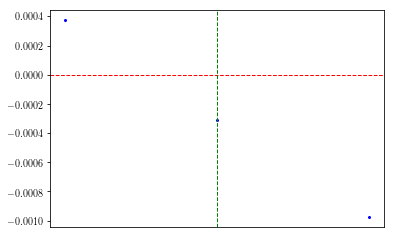

In [71]:
# resta = fstr_M31gd(rstr_M31gd[np.where(rstr_M31gd>0.1)]) - fdrk_M31gd(rstr_M31gd[np.where(rstr_M31gd>0.1)])


# mask, = np.where(abs(resta)<0.0005)


# plt.plot(pointMWgs, rest_MWgs,'.k',markersize=0.5)
plt.plot(pointM31gd[mask1], rest_M31gd[mask1],'o',color='b',markersize=2)
plt.xscale('log')
plt.axhline(0,ls='--', color='r',lw=1)
plt.axvline(req_M31gd,ls='--', color='g',lw=1)

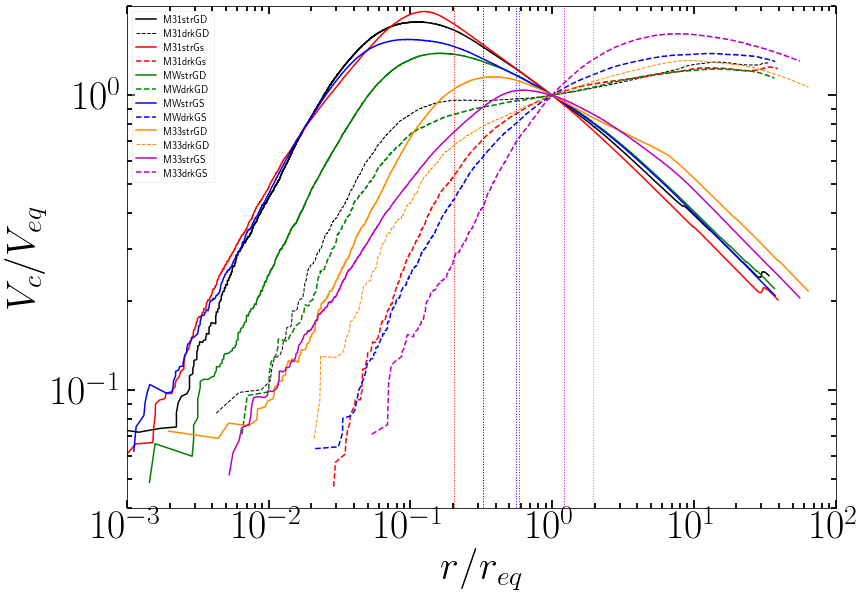

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)


ax.plot(rstr_M31gd/req_M31gd,Vstr_M31gd/fstr_M31gd(req_M31gd),'-',lw=1.5, color='k', label ='M31strGD')
ax.plot(rdrk_M31gd/req_M31gd,Vdrk_M31gd/fstr_M31gd(req_M31gd),'--',color='k', lw=1, label='M31drkGD')
ax.axvline(r50_M31gd/req_M31gd,ymin=0.001,ymax=100, ls=':', color='k',lw=1)

ax.plot(rstr_M31gs/req_M31gs,Vstr_M31gs/fstr_M31gs(req_M31gs),'-',lw=1.5, color='r', label ='M31strGs')
ax.plot(rdrk_M31gs/req_M31gs,Vdrk_M31gs/fstr_M31gs(req_M31gs),'--',color='r', lw=1.5, label='M31drkGs')
ax.axvline(r50_M31gs/req_M31gs,ymin=0.001,ymax=100, ls=':', color='r',lw=1)

ax.plot(rstr_MWgd/req_MWgd,Vstr_MWgd/fstr_MWgd(req_MWgd),'-',lw=1.5, color='g', label ='MWstrGD')
ax.plot(rdrk_MWgd/req_MWgd,Vdrk_MWgd/fstr_MWgd(req_MWgd),'--',color='g', lw=1.5, label='MWdrkGD')
ax.axvline(r50_MWgd/req_MWgd,ymin=0.001,ymax=100, ls=':', color='g',lw=1)

ax.plot(rstr_MWgs/req_MWgs,Vstr_MWgs/fstr_MWgs(req_MWgs),'-',lw=1.5, color='b', label ='MWstrGS')
ax.plot(rdrk_MWgs/req_MWgs,Vdrk_MWgs/fstr_MWgs(req_MWgs),'--',color='b', lw=1.5, label='MWdrkGS')
ax.axvline(r50_MWgs/req_MWgs,ymin=0.001,ymax=100, ls=':', color='b',lw=1)

ax.plot(rstr_M33gd/req_M33gd,Vstr_M33gd/fstr_M33gd(req_M33gd),'-',lw=1.5, color='darkorange', label ='M33strGD')
ax.plot(rdrk_M33gd/req_M33gd,Vdrk_M33gd/fstr_M33gd(req_M33gd),'--',color='darkorange', lw=1, label='M33drkGD')
ax.axvline(r50_M33gd/req_M33gd,ymin=0.001,ymax=100, ls=':', color='darkorange',lw=1)

ax.plot(rstr_M33gs/req_M33gs,Vstr_M33gs/fstr_M33gs(req_M33gs),'-',lw=1.5, color='m', label ='M33strGS')
ax.plot(rdrk_M33gs/req_M33gs,Vdrk_M33gs/fstr_M33gs(req_M33gs),'--',color='m', lw=1.5, label='M33drkGS')
ax.axvline(r50_M33gs/req_M33gs,ymin=0.001,ymax=100, ls=':', color='m',lw=1)

# ax.set_xticks([1e-3,1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax.set_xscale('log')

ax.set_xlim(0.001,100)
ax.set_yscale('log')
ax.set_yticks([1e-1,1e0], minor=True)
ax.set_ylim(0.04,2)
ax.set_ylabel(r'$V_{c}/V_{eq}$', fontsize=40)
ax.set_xlabel(r'$r/r_{eq}$', fontsize=40)

ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

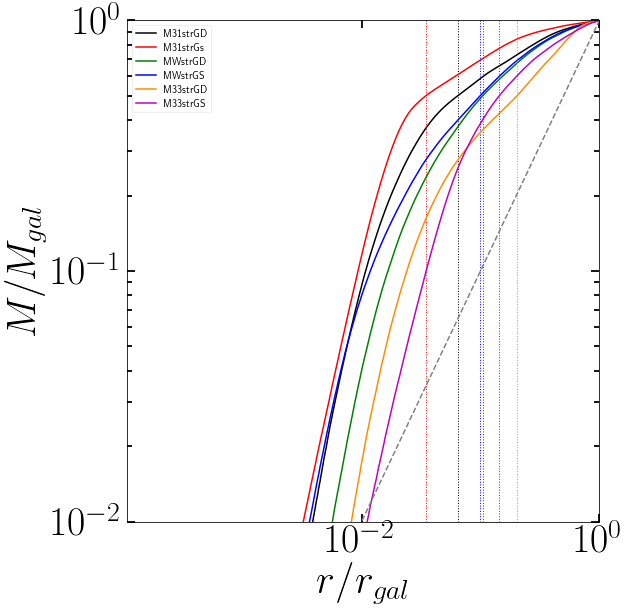

In [149]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

ax=fig.add_subplot(111)

ax.plot(rstr_M31gd[np.where(rstr_M31gd<r200_M31gd*0.15)]/(r200_M31gd*0.15),Mstr_M31gd[np.where(rstr_M31gd<r200_M31gd*0.15)]/Mgal_M31gd,
        '-',lw=1.5, color='k', label ='M31strGD')
ax.axvline(r50_M31gd/(r200_M31gd*0.15),ymin=0,ymax=1, ls=':', color='k',lw=1)

ax.plot(rstr_M31gs[np.where(rstr_M31gs<r200_M31gs*0.15)]/(r200_M31gs*0.15),Mstr_M31gs[np.where(rstr_M31gs<r200_M31gs*0.15)]/Mgal_M31gs,
        '-',lw=1.5, color='r', label ='M31strGs')
ax.axvline(r50_M31gs/(r200_M31gs*0.15),ymin=0,ymax=1, ls=':', color='r',lw=1)

ax.plot(rstr_MWgd[np.where(rstr_MWgd<r200_MWgd*0.15)]/(r200_MWgd*0.15),Mstr_MWgd[np.where(rstr_MWgd<r200_MWgd*0.15)]/Mgal_MWgd,
        '-',lw=1.5, color='g', label ='MWstrGD')
ax.axvline(r50_MWgd/(r200_MWgd*0.15),ymin=0,ymax=1, ls=':', color='g',lw=1)

ax.plot(rstr_MWgs[np.where(rstr_MWgs<r200_MWgs*0.15)]/(r200_MWgs*0.15),Mstr_MWgs[np.where(rstr_MWgs<r200_MWgs*0.15)]/Mgal_MWgs,
        '-',lw=1.5, color='b', label ='MWstrGS')
ax.axvline(r50_MWgs/(r200_MWgs*0.15),ymin=0,ymax=1, ls=':', color='b',lw=1)

ax.plot(rstr_M33gd[np.where(rstr_M33gd<r200_M33gd*0.15)]/(r200_M33gd*0.15),Mstr_M33gd[np.where(rstr_M33gd<r200_M33gd*0.15)]/Mgal_M33gd,
        '-',lw=1.5, color='darkorange', label ='M33strGD')
ax.axvline(r50_M33gd/(r200_M33gd*0.15),ymin=0,ymax=1, ls=':', color='darkorange',lw=1)

ax.plot(rstr_M33gs[np.where(rstr_M33gs<r200_M33gs*0.15)]/(r200_M33gs*0.15),Mstr_M33gs[np.where(rstr_M33gs<r200_M33gs*0.15)]/Mgal_M33gs,
        '-',lw=1.5, color='m', label ='M33strGS')
ax.axvline(r50_M33gs/(r200_M33gs*0.15),ymin=0,ymax=1, ls=':', color='m',lw=1)

ax.plot([0,1],'--',color='grey')
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xscale('log')

ax.set_xlim(0,1)
ax.set_yscale('log')
# ax.set_yticks([1e-1,1e0], minor=True)
ax.set_ylim(1e-2,1)
ax.set_ylabel(r'$M/M_{gal}$', fontsize=40)
ax.set_xlabel(r'$r/r_{gal}$', fontsize=40)

ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

In [144]:
ftot_M31gd = sint.interp1d(rtot_M31gd, Vtot_M31gd)
ftot_MWgd  = sint.interp1d(rtot_MWgd,  Vtot_MWgd)
ftot_M33gd = sint.interp1d(rtot_M33gd, Vtot_M33gd)

ftot_M31gs = sint.interp1d(rtot_M31gs, Vtot_M31gs)
ftot_MWgs  = sint.interp1d(rtot_MWgs,  Vtot_MWgs)
ftot_M33gs = sint.interp1d(rtot_M33gs, Vtot_M33gs)

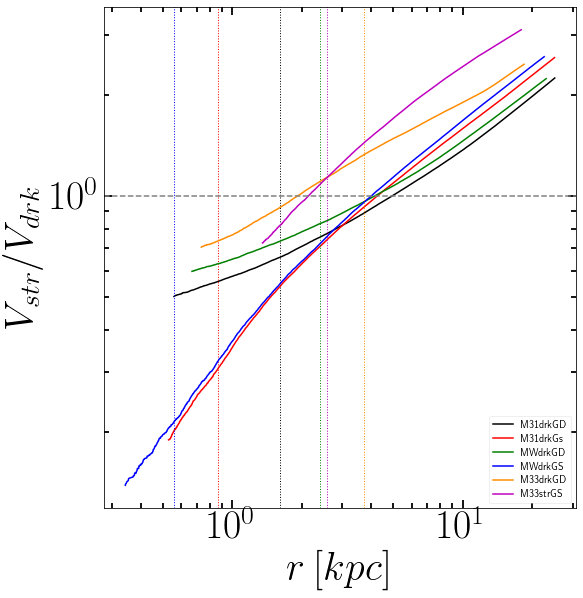

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)

ax.plot(pointM31gd,fdrk_M31gd(pointM31gd)/fstr_M31gd(pointM31gd),'-',lw=1.5, color='k', label ='M31drkGD')
# ax.plot(pointM31gd,fstr_M31gd(pointM31gd)/ftot_M31gd(pointM31gd),'--',lw=1.5, color='k', label ='M31totGD')
ax.axvline(r50_M31gd,ymin=0.001,ymax=100, ls=':', color='k',lw=1)

ax.plot(pointM31gs,fdrk_M31gs(pointM31gs)/fstr_M31gs(pointM31gs),'-',lw=1.5, color='r', label ='M31drkGs')
# ax.plot(pointM31gs,fstr_M31gs(pointM31gs)/ftot_M31gs(pointM31gs),'--',lw=1.5, color='r', label ='M31totGs')
ax.axvline(r50_M31gs,ymin=0.001,ymax=100, ls=':', color='r',lw=1)

ax.plot(pointMWgd,fdrk_MWgd(pointMWgd)/fstr_MWgd(pointMWgd),'-',lw=1.5, color='g', label ='MWdrkGD')
# ax.plot(pointMWgd,fstr_MWgd(pointMWgd)/ftot_MWgd(pointMWgd),'--',lw=1.5, color='g', label ='MWtotGD')
ax.axvline(r50_MWgd,ymin=0.001,ymax=100, ls=':', color='g',lw=1)

ax.plot(pointMWgs,fdrk_MWgs(pointMWgs)/fstr_MWgs(pointMWgs),'-',lw=1.5, color='b', label ='MWdrkGS')
# ax.plot(pointMWgs,fstr_MWgs(pointMWgs)/ftot_MWgs(pointMWgs),'--',lw=1.5, color='b', label ='MWtotGS')
ax.axvline(r50_MWgs/req_MWgs,ymin=0.001,ymax=100, ls=':', color='b',lw=1)

ax.plot(pointM33gd,fdrk_M33gd(pointM33gd)/fstr_M33gd(pointM33gd),'-',lw=1.5, color='darkorange', label ='M33drkGD')
# ax.plot(pointM33gd,fstr_M33gd(pointM33gd)/ftot_M33gd(pointM33gd),'--',lw=1.5, color='darkorange', label ='M33totGD')
ax.axvline(r50_M33gd,ymin=0.001,ymax=100, ls=':', color='darkorange',lw=1)

ax.plot(pointM33gs,fdrk_M33gs(pointM33gs)/fstr_M33gs(pointM33gs),'-',lw=1.5, color='m', label ='M33strGS')
# ax.plot(pointM33gs,fstr_M33gs(pointM33gs)/ftot_M33gs(pointM33gs),'--',lw=1.5, color='m', label ='M33totGS')
ax.axvline(r50_M33gs,ymin=0.001,ymax=100, ls=':', color='m',lw=1)

# ax.set_xticks([1e-3,1e-2,1e-1,1e0,1e1,1e2], minor=True)
ax.set_xscale('log')
# ax.set_xlim(0.001,100)
ax.set_yscale('log')
# ax.set_yticks([1e-1,1e0], minor=True)
# ax.set_ylim(0.04,2)
ax.set_ylabel(r'$V_{str}/V_{drk}$', fontsize=40)
ax.set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax.axhline(y=1,ls='--', color='grey')
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

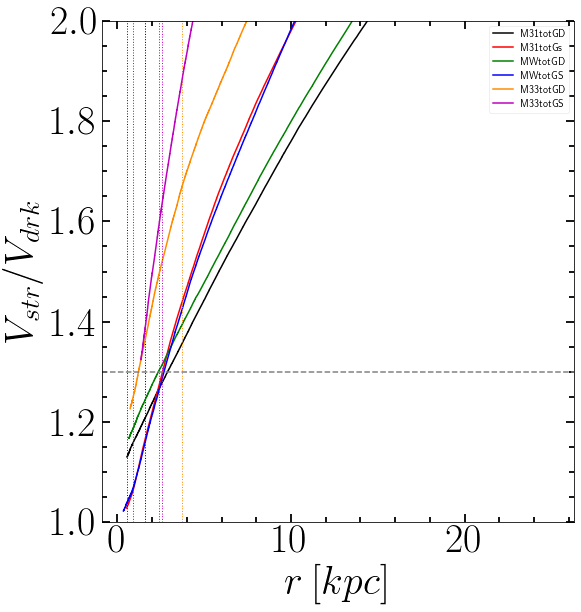

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)

# ax.plot(pointM31gd,fstr_M31gd(pointM31gd)/fdrk_M31gd(pointM31gd),'-',lw=1.5, color='k', label ='M31drkGD')
ax.plot(pointM31gd,ftot_M31gd(pointM31gd)/fstr_M31gd(pointM31gd),'-',lw=1.5, color='k', label ='M31totGD')
ax.axvline(r50_M31gd,ymin=0.001,ymax=100, ls=':', color='k',lw=1)

# ax.plot(pointM31gs,fstr_M31gs(pointM31gs)/fdrk_M31gs(pointM31gs),'-',lw=1.5, color='r', label ='M31drkGs')
ax.plot(pointM31gs,ftot_M31gs(pointM31gs)/fstr_M31gs(pointM31gs),'-',lw=1.5, color='r', label ='M31totGs')
ax.axvline(r50_M31gs,ymin=0.001,ymax=100, ls=':', color='r',lw=1)

# ax.plot(pointMWgd,fstr_MWgd(pointMWgd)/fdrk_MWgd(pointMWgd),'-',lw=1.5, color='g', label ='MWdrkGD')
ax.plot(pointMWgd,ftot_MWgd(pointMWgd)/fstr_MWgd(pointMWgd),'-',lw=1.5, color='g', label ='MWtotGD')
ax.axvline(r50_MWgd,ymin=0.001,ymax=100, ls=':', color='g',lw=1)

# ax.plot(pointMWgs,fstr_MWgs(pointMWgs)/fdrk_MWgs(pointMWgs),'-',lw=1.5, color='b', label ='MWdrkGS')
ax.plot(pointMWgs,ftot_MWgs(pointMWgs)/fstr_MWgs(pointMWgs),'-',lw=1.5, color='b', label ='MWtotGS')
ax.axvline(r50_MWgs/req_MWgs,ymin=0.001,ymax=100, ls=':', color='b',lw=1)

# ax.plot(pointM33gd,fstr_M33gd(pointM33gd)/fdrk_M33gd(pointM33gd),'-',lw=1.5, color='darkorange', label ='M33drkGD')
ax.plot(pointM33gd,ftot_M33gd(pointM33gd)/fstr_M33gd(pointM33gd),'-',lw=1.5, color='darkorange', label ='M33totGD')
ax.axvline(r50_M33gd,ymin=0.001,ymax=100, ls=':', color='darkorange',lw=1)

# ax.plot(pointM33gs,fstr_M33gs(pointM33gs)/fdrk_M33gs(pointM33gs),'-',lw=1.5, color='m', label ='M33strGS')
ax.plot(pointM33gs,ftot_M33gs(pointM33gs)/fstr_M33gs(pointM33gs),'-',lw=1.5, color='m', label ='M33totGS')
ax.axvline(r50_M33gs,ymin=0.001,ymax=100, ls=':', color='m',lw=1)

# ax.set_xticks([1e-3,1e-2,1e-1,1e0,1e1,1e2], minor=True)
# ax.set_xscale('log')
# ax.set_xlim(0.001,100)
# ax.set_yscale('log')
# ax.set_yticks([1e-1,1e0], minor=True)
ax.set_ylim(1,2)
ax.set_ylabel(r'$V_{str}/V_{drk}$', fontsize=40)
ax.set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax.axhline(y=1.3,ls='--', color='grey')
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
plt.legend(framealpha=0.3)

plt.show()

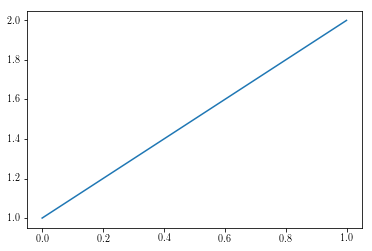

In [129]:
plt.plot([])